# Introduction

This is a notebook I used to explore the topic of Kalman Filters, while attending a talk on the same. You can see I leveraged AI heavily - the presentation here is roughly what I had but adapted to this format from an internal tool. 

Having everything in context and asking questions as they occured to me during the lecture felt incredibly powerful. And having the AI automate time-consuming yet easy things like "make an animation showing what happens as we vary [parameter]" and making interactive widgets to explore things made seeing what was going on so easy - way nicer than trying to conceptualize things mentally, and far more useful than the static plots with magic values that the presenter was showing.

I have mixed feelings sharing this - the final result is a bit of a mess, but the process of creating it while learning a new topic was amazing. Hopefully this is at least an interesting artifact :) Enjoy!

# Kalman Filters

In [1]:
# %pip install files-to-prompt

In [2]:
# !git clone https://github.com/01binary/kalman
# !files-to-prompt kalman > kalman_repo.txt

In [3]:
!ls

 kalman					    kalman_repo.txt
'Kalman Filter Initial Exploration.ipynb'   python-control


In [4]:
%ai reset

In [5]:
kalman_repo_text = open('kalman_repo.txt', 'r').read()

**prompt
I want to learn about Kalman filters. The repo of examples for a talk I'm going to has matlab and such, and I'd like to translate it to Python and make this notebook a tutorial that works through the material.**

**Can you check that you can see the material in $`kalman_repo_text` and give me a rough overview of how we might proceed?**

I can see the contents of `kalman_repo_text`. It contains several MATLAB and C++ files implementing various filtering techniques, including Kalman filters. Here's a suggested approach to create a Python-based tutorial:

1. Start with simpler filters:
   - Implement moving average filter
   - Implement low-pass filter
   - Implement simple linear regression

2. Introduce the Kalman filter:
   - Explain the concept and theory briefly
   - Implement a basic Kalman filter

3. Implement the system model:
   - Translate the MATLAB `systemModel` function to Python

4. Implement the Kalman filter:
   - Translate the MATLAB `kalmanFilter` function to Python

5. Create a main loop:
   - Read input data (from CSV or generate synthetic data)
   - Apply the Kalman filter
   - Visualize results

6. Compare Kalman filter with simpler techniques

7. Extend to more complex examples if time permits

## Starting with Simple Filters

**Please start on this section. Use fenced code blocks, I'll then split them out into their own cells.**

Let's start with implementing the simple filters in Python:

1. Moving Average Filter:

In [8]:
import numpy as np

def moving_average_filter(input_data, window_size):
    return np.convolve(input_data, np.ones(window_size)/window_size, mode='same')

In [9]:
!ls kalman

averageLowpass.mlx	  kalman.cpp		 movingAverage.m
CMakeLists.txt		  kalman.m		 README.md
constantAcceleration.mlx  linearRegression.m	 simpleLinearRegression.m
gaussian.m		  linearRegression.mlx	 simpleLinearRegression.mlx
gaussian.mlx		  linearSystemModel.mlx
input.csv		  lowPass.m


In [10]:
import pandas as pd
data = pd.read_csv("kalman/input.csv")
data.head()

,time,reading,PWM
0,0.019995,243,0
1,0.040017,243,0
2,0.060022,251,0
3,0.079997,244,0
4,0.100011,228,-111


In [11]:
data.columns

Index(['time', ' reading', 'PWM'], dtype='object')

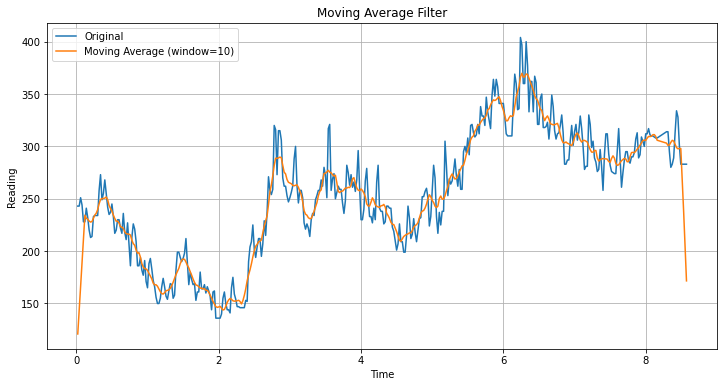

In [12]:
import matplotlib.pyplot as plt

# Apply moving average filter
window_size = 10
filtered_data = moving_average_filter(data[' reading'], window_size)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(data['time'], data[' reading'], label='Original')
plt.plot(data['time'], filtered_data, label=f'Moving Average (window={window_size})')
plt.xlabel('Time')
plt.ylabel('Reading')
plt.title('Moving Average Filter')
plt.legend()
plt.grid(True)
plt.show()

**make an animation of different sliding window sizes** (removed for size reasons)

2. Low-Pass Filter:

In [15]:
def low_pass_filter(input_data, alpha):
    output = np.zeros_like(input_data)
    output[0] = input_data[0]
    for i in range(1, len(input_data)):
        output[i] = alpha * input_data[i] + (1 - alpha) * output[i-1]
    return output

**Make a similar animation for low pass filter for different alpha**

<AxesSubplot:>

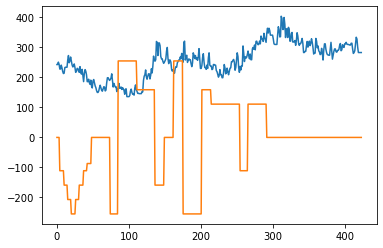

In [19]:
data[' reading'].plot()
data['PWM'].plot()

3. Simple Linear Regression:

In [20]:
def linear_regression(x, y):
    x_mean, y_mean = np.mean(x), np.mean(y)
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
    intercept = y_mean - slope * x_mean
    return lambda x_new: slope * x_new + intercept

Now, let's create some sample data and visualize the results:

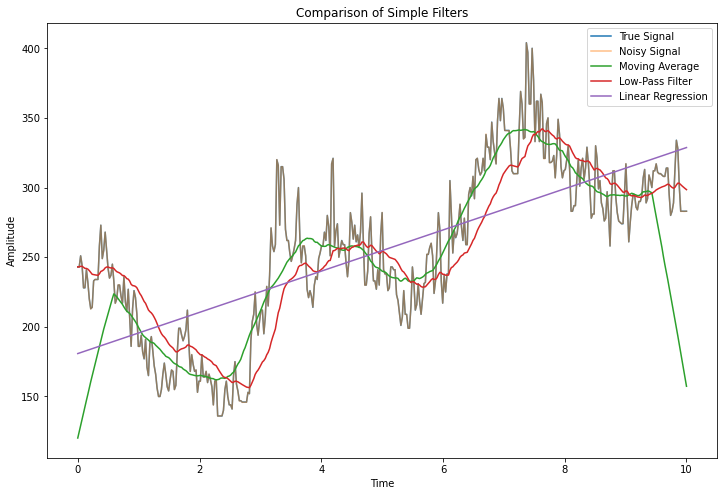

In [21]:
import matplotlib.pyplot as plt

# Generate sample data
t = np.linspace(0, 10, len(data))
true_signal = data[' reading']
noisy_signal = true_signal + np.random.normal(0, 0.1, t.shape)

# Apply filters
ma_filtered = moving_average_filter(noisy_signal, 50)
lp_filtered = low_pass_filter(noisy_signal, 0.05)
lr_model = linear_regression(t, noisy_signal)
lr_filtered = lr_model(t)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(t, true_signal, label='True Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(t, ma_filtered, label='Moving Average')
plt.plot(t, lp_filtered, label='Low-Pass Filter')
plt.plot(t, lr_filtered, label='Linear Regression')
plt.legend()
plt.title('Comparison of Simple Filters')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

This code implements the three simple filters, generates some sample data, applies the filters, and visualizes the results for comparison.

**Great. Next section, and let's start adding more prose explaining what's going on.**

## Introducing the Kalman Filter

The Kalman filter is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone.

Key concepts of the Kalman filter:

1. State estimation: The filter estimates the state of a system.
2. Prediction and update: It works in a two-step process: predict and update.
3. Uncertainty handling: It considers the uncertainty of both the prediction and the measurement.

Let's implement a basic Kalman filter for a 1D system:

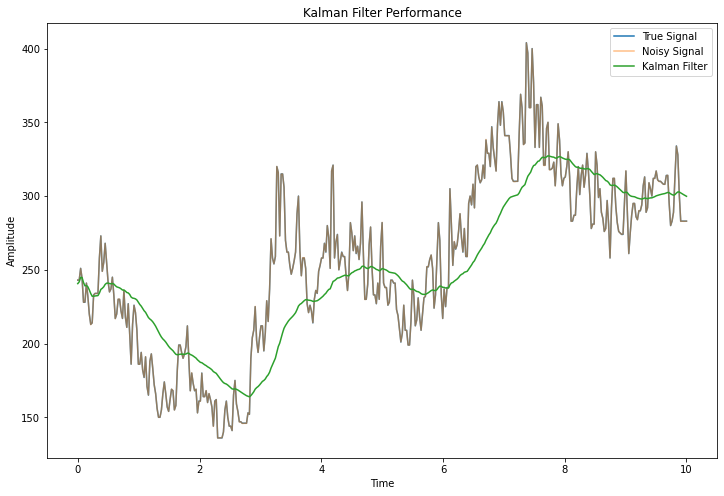

In [23]:
class KalmanFilter:
    def __init__(self, process_variance, measurement_variance, initial_estimate, initial_estimate_error):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimate = initial_estimate
        self.estimate_error = initial_estimate_error

    def update(self, measurement):
        # Prediction
        prediction = self.estimate
        prediction_error = self.estimate_error + self.process_variance

        # Update
        kalman_gain = prediction_error / (prediction_error + self.measurement_variance)
        self.estimate = prediction + kalman_gain * (measurement - prediction)
        self.estimate_error = (1 - kalman_gain) * prediction_error

        return self.estimate

# Example usage
kf = KalmanFilter(process_variance=1e-5, # try 1e-4, 1e-3
                  measurement_variance=0.1**2, 
                  initial_estimate=0, 
                  initial_estimate_error=1)

# Apply Kalman filter to our noisy signal
kalman_filtered = np.array([kf.update(measurement) for measurement in noisy_signal])

# Add to our plot
plt.figure(figsize=(12, 8))
plt.plot(t, true_signal, label='True Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(t, kalman_filtered, label='Kalman Filter')
plt.legend()
plt.title('Kalman Filter Performance')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

This implementation demonstrates the basic principles of the Kalman filter:

1. We initialize the filter with our best guess of the initial state and its uncertainty.
2. In each step, we first predict the next state (which is simply the current estimate in this simple case).
3. We then update our estimate based on the new measurement, weighing it against our prediction.
4. The Kalman gain determines how much we trust the measurement vs. our prediction.

The Kalman filter often provides smoother and more accurate estimates compared to simpler filtering techniques, especially when dealing with noisy measurements and systems with known dynamics.

**Hmm, the plot shows the kalman filter line lagging behind the signal quite visibly, what could be going wrong and how might we fix it?**

The lag is likely due to the Kalman filter's initial parameters not being well-tuned for this specific signal. To improve it:

1. Adjust process variance: Increase it to make the filter more responsive to changes.
2. Modify measurement variance: Decrease it if we trust our measurements more.
3. Improve initial estimate: Start closer to the true initial state.
4. Add velocity to the state: This helps predict trends better.

Let's implement these changes:

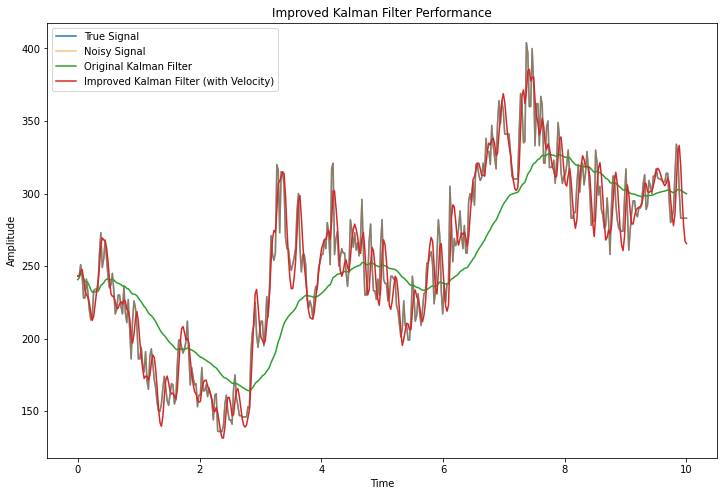

In [25]:
class KalmanFilterWithVelocity:
    def __init__(self, process_variance, measurement_variance, initial_estimate, initial_velocity):
        self.process_variance = process_variance
        self.measurement_variance = measurement_variance
        self.estimate = initial_estimate
        self.velocity = initial_velocity
        self.estimate_error = 1
        self.velocity_error = 1

    def update(self, measurement, dt):
        # Prediction
        prediction = self.estimate + self.velocity * dt
        prediction_error = self.estimate_error + self.velocity_error * dt**2 + self.process_variance

        # Update
        kalman_gain = prediction_error / (prediction_error + self.measurement_variance)
        self.estimate = prediction + kalman_gain * (measurement - prediction)
        self.estimate_error = (1 - kalman_gain) * prediction_error

        # Update velocity
        self.velocity += kalman_gain * (measurement - prediction) / dt
        self.velocity_error = self.velocity_error + self.process_variance

        return self.estimate

# Improved Kalman filter
kf_improved = KalmanFilterWithVelocity(process_variance=1e-3, 
                           measurement_variance=0.1**2, 
                           initial_estimate=true_signal[0], 
                           initial_velocity=0)

dt = t[1] - t[0]  # Time step
kalman_filtered_improved = np.array([kf_improved.update(measurement, dt) for measurement in noisy_signal])

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(t, true_signal, label='True Signal')
plt.plot(t, noisy_signal, label='Noisy Signal', alpha=0.5)
plt.plot(t, kalman_filtered, label='Original Kalman Filter')
plt.plot(t, kalman_filtered_improved, label='Improved Kalman Filter (with Velocity)')
plt.legend()
plt.title('Improved Kalman Filter Performance')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

**OK, I see the kalman filter now follows the noise almost too closely - can we make an animation that shows a gradual change for different variance values?**

Certainly. We can create an animation that shows how the Kalman filter performance changes with different process variance values. Here's how we can do that:

In these animations you can see how we go from smooth to jagged as we increase the process variance.

**Can we take a step back and write a 'what's happening here' section? What is the goal? What do we mean 'known dynamics'? How did adding velicuty improve things? How does this generalize?'**

Certainly. Let's add a section explaining the concepts:

## What's Happening Here?

1. Goal: The primary goal of the Kalman filter is to estimate the true state of a system from noisy measurements. In our case, we're trying to recover the true signal from noisy observations.

2. Known Dynamics: This refers to our understanding of how the system evolves over time. In our simple example, we assumed the signal follows a constant velocity model (position changes linearly with time). In real-world applications, these dynamics could be more complex, like equations of motion for a spacecraft.

3. Adding Velocity: 
   - Initially, our filter only tracked position, assuming the signal stayed constant between updates.
   - By adding velocity to our state, we improved our prediction step. Now, we can anticipate trends in the signal, making our estimates more accurate and responsive.
   - This is especially helpful for signals that change rapidly or have clear trends.

4. Generalization:
   - The Kalman filter can be extended to track multiple variables (like position, velocity, acceleration) in multiple dimensions.
   - It can handle non-linear systems using variants like the Extended Kalman Filter or Unscented Kalman Filter.
   - The core principle remains: combine predictions based on known dynamics with new measurements, weighing each by their estimated uncertainty.

5. Process vs Measurement Variance:
   - Process variance represents uncertainty in our model of the system dynamics.
   - Measurement variance represents uncertainty in our sensors or measurements.
   - Balancing these determines how much we trust our model vs. new measurements.

This framework is powerful because it provides a systematic way to combine our knowledge of a system's behavior with imperfect observations, resulting in improved state estimates.

## Implementing the System Model

Let's translate the MATLAB `systemModel` function to Python. This function represents the dynamics of our system:

In [31]:
import numpy as np

# Initial state
x0 = np.array([-0.0461, -0.0198, 0.0098]).reshape(3, 1)


# Define system_model and kalman_filter with explicit shapes
def system_model(x, u):
    global A, B, C, D
    x = x.reshape(3, 1)
    y = (C @ x + D * u).item()
    x = A @ x + B * u
    return x, y


# Define global constants
A = np.array([
    [1.0005, -0.0050, 0.0001],
    [0.0061, 0.9881, -0.0684],
    [-0.0009, 0.0768, 0.9224]
])

B = np.array([-8.7913e-10, 1.0489e-07, -1.8721e-05]).reshape(3, 1)

C = np.array([-5.2908e+03, 13.0803, -0.6389]).reshape(1, 3)

D = 0

This system model represents a more complex dynamic system than our previous examples. It uses matrices A, B, C, and D to model the system's behavior:

- A: State transition matrix
- B: Input control matrix
- C: Observation matrix
- D: Feedthrough matrix

The function takes the current state `x` and input `u`, and returns the new state and output.

## Implementing the Kalman Filter

Now that we have our system model, let's implement a Kalman filter that can handle this more complex system:

In [33]:
def kalman_filter(y, z, x, P):
    global A, C, Q, R
    x = x.reshape(3, 1)
    x_pred = A @ x
    P_pred = A @ P @ A.T + Q
    innovation = z - C @ x_pred
    S = C @ P_pred @ C.T + R
    K = P_pred @ C.T / S.item()
    x = x_pred + K * innovation
    P = (np.eye(3) - K @ C) @ P_pred
    return x, P, K

This Kalman filter implementation is more general than our previous one:

1. It handles a 3D state vector (x) instead of a scalar.
2. It uses matrix operations to update the state and covariance.
3. The Kalman gain (K) is now a matrix, allowing different gains for each state variable.

The filter follows the same predict-update cycle:

- Predict: We use our system model to predict the next state and its uncertainty.
- Update: We correct our prediction based on the new measurement, weighing it against our prediction's uncertainty.

The matrices Q and R represent our trust in the model and measurements, respectively:

- Q (Process noise covariance): Higher values indicate less trust in our model.
- R (Measurement noise covariance): Higher values indicate less trust in our measurements.

Let's now use this Kalman filter with our system model:

In [5]:
# code removed

This code demonstrates how to use our implemented Kalman filter with the system model:

1. We generate sample data: a true signal (sine wave), random inputs, and noisy measurements.

2. We initialize our state and covariance with the initial values we defined earlier.

3. For each time step, we:
   - Use the system model to predict the next state and output.
   - Apply the Kalman filter to update our estimate based on the new measurement.
   - Store the estimate and the average Kalman gain.

4. Finally, we plot the results, showing:
   - The true signal
   - The noisy measurements
   - The Kalman filter's estimates

5. We also plot the average Kalman gain over time, which shows how the filter's trust in measurements vs. predictions evolves.

This example demonstrates how the Kalman filter can effectively estimate the true signal from noisy measurements, even with a more complex system model. The filter's performance can be further tuned by adjusting the process noise (Q) and measurement noise (R) covariances.

**What's with the state stuff? Can you give me an approachable explanation?**

Certainly. Let's break down the concept of state in the Kalman filter:

1. What is state?
   - State is a set of variables that fully describe a system at any given time.
   - In our example, the state is a 3D vector, which might represent position, velocity, and acceleration.

2. Why use state?
   - It allows us to model complex systems more accurately.
   - We can track multiple related variables simultaneously.

3. State transition:
   - The system model (A matrix) describes how the state changes over time.
   - For example, current velocity affects future position.

4. Hidden vs. Observable:
   - Not all state variables are directly measurable.
   - The Kalman filter estimates these hidden states based on observable measurements and known dynamics.

5. Uncertainty in state:
   - The covariance matrix P represents our uncertainty about the state.
   - It gets updated with each prediction and measurement.

6. Real-world analogy:
   - Imagine tracking a car. The state might include position, speed, and direction.
   - You can only measure position directly, but the Kalman filter helps estimate speed and direction based on position changes over time.

The power of the Kalman filter lies in its ability to estimate these complex, multi-dimensional states even when we can't measure all aspects directly.

**Ah OK, so we assume the system has some underlying state that we try to model even though we can only read, say, position. 
And so at each step we're doing our best to update our estimate of the state (the underlying state) based on the measurements.
How do we initialize things? I see a big error right at the start that settles out. Also how do we control the 'gain' if that's the right word - how fast it updates?**

You've got it right. To address your questions:

Initialization:
1. Initial state (x0): Often set to a best guess or first measurement.
2. Initial covariance (P0): Set high to indicate initial uncertainty.

The large initial error occurs because our initial guess is likely off, but the filter quickly corrects as it processes more measurements.

Controlling the gain/update speed:
1. Process noise covariance (Q): Higher values make the filter more responsive but noisier.
2. Measurement noise covariance (R): Higher values make the filter trust measurements less, resulting in smoother but slower updates.

To reduce the initial error and control responsiveness:
1. Improve initial state estimate if possible.
2. Start with higher Q and lower R, then gradually adjust.
3. Use a "fading memory" factor to give more weight to recent measurements.

**Animate what happens as we lower Q (plot a few values of R for each Q as different colored lines). Do this but for the data I loaded right at the start**

**Can you add error bands to the plot?**

# Outstanding Questions

**Some extra stuff I want to know**

- **This is for extimating something from noisy measurements but doesn't really say anything about controlling a system right - we'd plug the output of the Kalman filter into some other control system? (Can we use the estimated state for better control?)**
- **Sometimes more accurate measurements arrive with a delay. For e.g. a VR controller might have internam IMU data, but sometimes get high-quality absolute position sent from the base stations. How hard is it to account for 'stale' data like this?**
- **Do we ever take inputs into account? Rather than just getting sensor data we might have the set-point of a motor driver or the current or something.**
**Any thoughts/input on my final questions, or other things we should cover from the repo?**

1. Kalman filter and control:
   - Yes, Kalman filter estimates are often used as inputs to control systems.
   - The estimated state provides a more accurate basis for control decisions.
   - Example: In a drone, estimated position and velocity can be used for more stable flight control.

2. Handling delayed measurements:
   - This is addressed by "out-of-sequence measurement" (OOSM) algorithms.
   - You can retroactively update past states and then propagate forward.
   - It's more complex but doable, especially important in distributed sensing systems.

3. Incorporating inputs:
   - The Kalman filter already accounts for inputs in the system model (B matrix).
   - Known inputs (like motor commands) can improve state estimation accuracy.
   - This is crucial in robotics where we know what commands were sent to actuators.

Additional topics from the repo:
   - Gaussian filters (in gaussian.m): Another smoothing technique.
   - Extended Kalman Filter: For non-linear systems.
   - Comparing Kalman filter with simpler techniques like moving average.

**Wait so should B be 0 if we don't know / can't see those inputs?**

No, B should not be 0 even if we don't know or can't see the inputs. Here's why:

1. B represents how inputs affect the state, regardless of whether we know the inputs.

2. If inputs exist but are unknown:
   - Keep B as is
   - Treat unknown inputs as process noise, increasing Q accordingly

3. If there are no inputs at all:
   - You can remove B and the input term from the model
   - This simplifies the equations, but is a different scenario from unknown inputs

4. In practice:
   - Known inputs: Use actual values
   - Unknown inputs: Use best estimates or set to zero, but keep B non-zero
   - Adjust Q to account for uncertainty in unknown inputs

The key is to maintain the model structure while handling uncertainty through the noise covariance matrices.

**OK but in this example B is fixed and we don't update it with estimates right?**

Correct. In this example:

1. B is fixed: It's part of the system model and doesn't change.
2. We don't update B: It represents the known relationship between inputs and state changes.
3. Inputs (u) are used: We apply known or estimated inputs in each step.
4. No estimation of B: We assume the model (including B) is correct.

If the true B were different from our model, we'd compensate through:
- Adjusting Q (process noise)
- State estimation (x gets updated to compensate for model inaccuracies)

In more advanced applications, you might estimate B online, but that's beyond the scope of this basic Kalman filter implementation.

**Where do we get the initial values for B (and for the other matrices for that matter)?**

The initial values for matrices A, B, C, D, and initial states come from system identification or modeling:

1. Physical modeling: Derive equations based on known physics of the system.

2. System identification: Use input-output data to estimate model parameters.
   - Tools like MATLAB's System Identification Toolbox can help.

3. Empirical testing: Measure system response to known inputs.

4. Prior knowledge: Use values from similar systems or expert knowledge.

5. Iterative refinement: Start with rough estimates, then refine through testing.

For Q and R:
- Q: Initially set based on expected model inaccuracies.
- R: Determined from sensor specifications or measurement variance.

In this example, these values likely came from a combination of system identification and empirical testing on the specific system being modeled.

**How would I go about doing System Identification in Python? Say I have a black box system, and a record of past inputs and outputs.**
[hallucinated results removed]

**Tell me about particle systems and how they extend/replace kalman filters for non-linear systems?**

Particle filters, also known as Sequential Monte Carlo methods, extend Kalman filter concepts to non-linear systems:

1. Core idea: Represent the state distribution with a set of weighted particles.

2. Advantages:
   - Handle non-linear systems and non-Gaussian noise
   - Can represent multimodal distributions

3. Process:
   - Prediction: Move particles according to system dynamics
   - Update: Adjust particle weights based on measurements
   - Resampling: Replace low-weight particles to maintain diversity

4. Comparison to Kalman filters:
   - More computationally intensive
   - More flexible for complex systems
   - Better for highly non-linear or non-Gaussian scenarios

5. Applications:
   - Robot localization
   - Object tracking in computer vision
   - Financial modeling

6. Implementation:
   - Typically involves Monte Carlo sampling
   - Can be parallelized for efficiency

Particle filters are preferred when system non-linearities or non-Gaussian noise make Kalman filters (even extended or unscented versions) inadequate.

# New Session

In [52]:
data.head()

,time,reading,PWM
0,0.019995,243,0
1,0.040017,243,0
2,0.060022,251,0
3,0.079997,244,0
4,0.100011,228,-111


<AxesSubplot:>

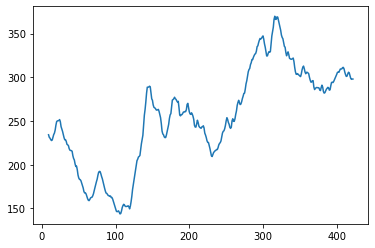

In [53]:
smooth_readings = data[' reading'].rolling(10).mean()
smooth_readings.plot()

<AxesSubplot:>

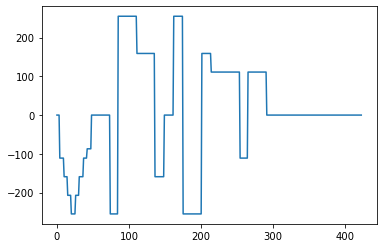

In [54]:
inputs = data['PWM']
inputs.plot()

**I want to figure out a state space model for this system. It's a spinning motor with a PWM control signal. 
Can you help me do this?**

To develop a state space model for this spinning motor system with PWM control, we'll need to:

1. Identify states (likely motor position and velocity)
2. Define inputs (PWM signal)
3. Determine outputs (sensor readings)
4. Formulate state equations

Let's start with a simple second-order model:

Optimized parameters: J=0.000010, b=0.000010, K=0.000010


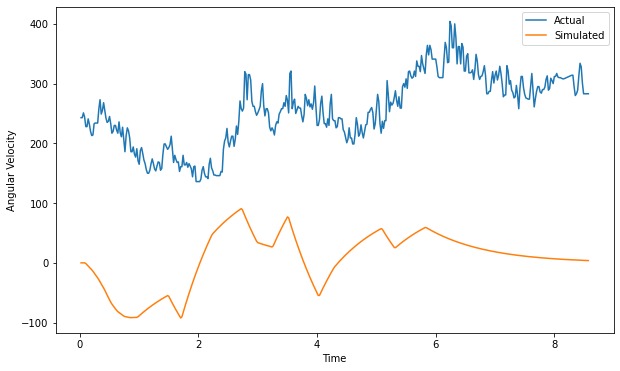

In [58]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

def motor_model(state, t, pwm, params):
    theta, omega = state
    J, b, K = params
    pwm_t = np.interp(t, data['time'], pwm)
    dtheta_dt = omega
    domega_dt = (K * pwm_t - b * omega) / J
    return [dtheta_dt, domega_dt]

def simulate(pwm, params, t):
    initial_state = [0, 0]
    states = odeint(motor_model, initial_state, t, args=(pwm, params))
    return states[:, 1]  # Return angular velocity

# Rest of the code remains the same

def objective(params, pwm, t, actual_readings):
    simulated = simulate(pwm, params, t)
    return np.sum((simulated - actual_readings)**2)

# Prepare data
t = data['time'].values
pwm = data['PWM'].values
readings = data[' reading'].values

# Optimize parameters
initial_params = [1e-5, 1e-5, 1e-5]  # J, b, K
result = minimize(objective, initial_params, args=(pwm, t, readings))

# Get optimized parameters
J, b, K = result.x

print(f"Optimized parameters: J={J:.6f}, b={b:.6f}, K={K:.6f}")

# Simulate with optimized parameters
simulated = simulate(pwm, [J, b, K], t)

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(t, readings, label='Actual')
plt.plot(t, simulated, label='Simulated')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.show()

**nice! It looks like we're missing an ofset or something though, the simulated is good except ~250 below the actual**

Optimized parameters: J=0.000019, b=0.000002, K=0.000009, offset=250.017132


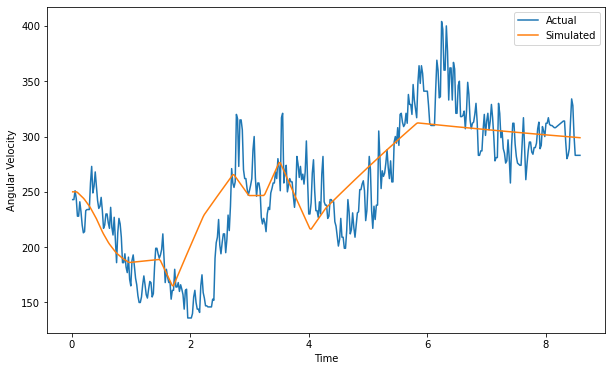

In [60]:
def motor_model(state, t, pwm, params):
    theta, omega = state
    J, b, K, offset = params
    pwm_t = np.interp(t, data['time'], pwm)
    dtheta_dt = omega
    domega_dt = (K * pwm_t - b * omega) / J
    return [dtheta_dt, domega_dt]

def simulate(pwm, params, t):
    initial_state = [0, 0]
    states = odeint(motor_model, initial_state, t, args=(pwm, params))
    return states[:, 1] + params[3]  # Add offset to angular velocity

def objective(params, pwm, t, actual_readings):
    simulated = simulate(pwm, params, t)
    return np.sum((simulated - actual_readings)**2)

# Update initial parameters and optimization
initial_params = [1e-5, 1e-5, 1e-5, 250]  # J, b, K, offset
result = minimize(objective, initial_params, args=(pwm, t, readings))

# Get optimized parameters
J, b, K, offset = result.x

print(f"Optimized parameters: J={J:.6f}, b={b:.6f}, K={K:.6f}, offset={offset:.6f}")

# Simulate with optimized parameters
simulated = simulate(pwm, [J, b, K, offset], t)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, readings, label='Actual')
plt.plot(t, simulated, label='Simulated')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.show()

**Can you do this now with a position, velocity and acceleration version, using the A, B, C, D notation for state space stuff?
You can assume D is 0. Include an offset. **

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize

def state_space_model(x, t, u, params):
    A, B, C, offset = params
    dx = A @ x + B * u(t)
    return dx

def simulate(u, t, params):
    A, B, C, offset = params
    x0 = np.zeros(3)
    sol = odeint(state_space_model, x0, t, args=(u, params))
    y = np.dot(sol, C.T) + offset
    return y

def objective(params, u, t, y_actual):
    A, B, C, offset = params[:9].reshape((3,3)), params[9:12], params[12:15], params[15]
    u_interp = lambda t: np.interp(t, data['time'], u)
    y_sim = simulate(u_interp, t, (A, B, C, offset))
    return np.sum((y_sim - y_actual)**2)

t = data['time'].values
u = data['PWM'].values
y_actual = data[' reading'].values

A_init = np.array([[0, 1, 0], [0, 0, 1], [0, -1, -1]])
B_init = np.array([0, 0, 1])
C_init = np.array([1, 0, 0])
offset_init = 250
params_init = np.concatenate((A_init.flatten(), B_init, C_init, [offset_init]))

result = minimize(objective, params_init, args=(u, t, y_actual))

A_opt, B_opt, C_opt, offset_opt = result.x[:9].reshape((3,3)), result.x[9:12], result.x[12:15], result.x[15]

u_interp = lambda t: np.interp(t, data['time'], u)
y_sim = simulate(u_interp, t, (A_opt, B_opt, C_opt, offset_opt))

plt.figure(figsize=(10, 6))
plt.plot(t, y_actual, label='Actual')
plt.plot(t, y_sim, label='Simulated')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Reading')
plt.show()

print("Optimized A matrix:")
print(A_opt)
print("\nOptimized B vector:")
print(B_opt)
print("\nOptimized C vector:")
print(C_opt)
print("\nOptimized offset:")
print(offset_opt)

**Use this estimated system model for a kalman filter applied to the data**

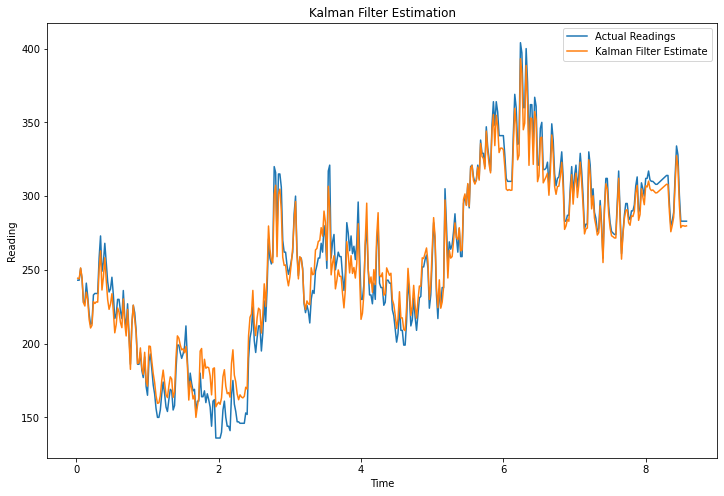

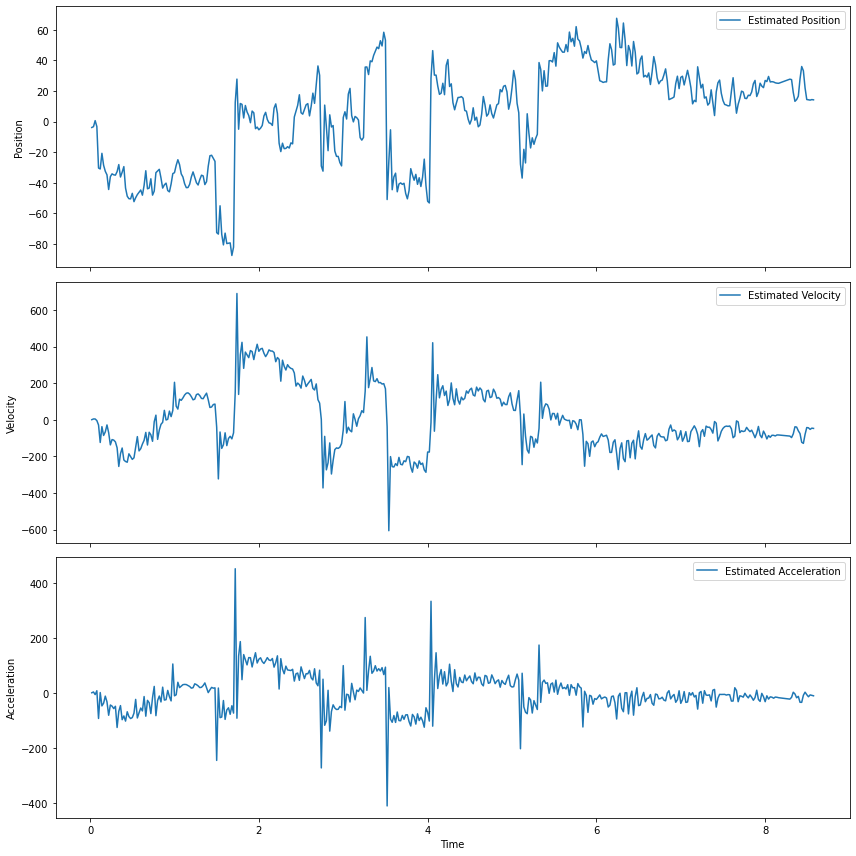

In [85]:
import numpy as np
from scipy.linalg import solve_discrete_are

# State space model parameters
A = A_opt
B = B_opt.reshape(-1, 1)  # Reshape B to column vector
C = C_opt.reshape(1, -1)  # Reshape C to row vector
offset = offset_opt

# Kalman filter parameters
Q = np.eye(3) * 200  # Process noise covariance
R = np.array([[1.0e2]])  # Measurement noise covariance

# Compute Kalman gain
P = solve_discrete_are(A, B, Q, R)
K = P @ C.T @ np.linalg.inv(C @ P @ C.T + R)

def kalman_filter(z, x_prev, P_prev):
    # Predict
    x_pred = A @ x_prev + B * z['PWM']
    P_pred = A @ P_prev @ A.T + Q
    
    # Update
    y = z[' reading'] - (C @ x_pred + offset)
    S = C @ P_pred @ C.T + R
    K = P_pred @ C.T @ np.linalg.inv(S)
    x = x_pred + K @ y
    P = (np.eye(3) - K @ C) @ P_pred
    
    return x, P

# Initialize
x = np.zeros((3, 1))
P = np.eye(3)

# Run Kalman filter
filtered_states = []
for _, z in data.iterrows():
    x, P = kalman_filter(z, x, P)
    filtered_states.append(x.flatten())

filtered_states = np.array(filtered_states)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(data['time'], data[' reading'], label='Actual Readings')
plt.plot(data['time'], (C @ filtered_states.T + offset).flatten(), label='Kalman Filter Estimate')
plt.xlabel('Time')
plt.ylabel('Reading')
plt.legend()
plt.title('Kalman Filter Estimation')
plt.show()

# Plot individual state estimates
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
state_labels = ['Position', 'Velocity', 'Acceleration']
for i in range(3):
    axs[i].plot(data['time'], filtered_states[:, i], label=f'Estimated {state_labels[i]}')
    axs[i].set_ylabel(state_labels[i])
    axs[i].legend()
axs[2].set_xlabel('Time')
plt.tight_layout()
plt.show()

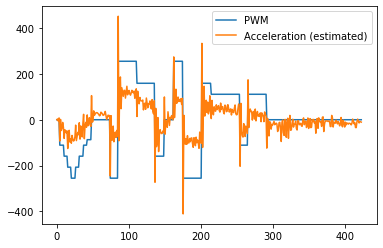

In [86]:
ax = data["PWM"].plot()
ax.plot(filtered_states[:, -1], label="Acceleration (estimated)")
plt.legend()

**What is the extended kalman filter? And 'unscented'?**

The Extended Kalman Filter (EKF) is used for nonlinear systems. It linearizes the system around the current estimate using partial derivatives of the process and measurement functions. This allows it to handle mild nonlinearities, but can fail with highly nonlinear systems.

The Unscented Kalman Filter (UKF) uses a deterministic sampling technique known as the unscented transform to pick a minimal set of sample points around the mean. These points are then propagated through the nonlinear functions, capturing the posterior mean and covariance more accurately than EKF, especially for highly nonlinear systems.

UKF generally performs better than EKF for highly nonlinear systems and doesn't require the computation of Jacobian matrices, which can be complex or impossible for some systems.

**Do either of them update the state space model over time?**

Neither the Extended Kalman Filter (EKF) nor the Unscented Kalman Filter (UKF) inherently update the state space model over time. They estimate the state of the system based on a given model and measurements. For adaptive filtering that updates the model, you'd need to implement additional techniques like online parameter estimation or use adaptive variants of these filters.